<h1><center>Generative Adversarial Networks - CycleGAN for MNIST Image Generation</center></h1>

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
import scipy.ndimage.interpolation
from tensorflow.examples.tutorials.mnist import input_data

import warnings
warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Training Params

learning_rate = 0.0002
batch_size = 32
epochs = 100000


# Network params
image_dimension = 784 # img size is "28 X 28"
H_dim = 128

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [3]:
# Define placeholders for external input

X_A = tf.placeholder(tf.float32, shape = [None, image_dimension])
X_B = tf.placeholder(tf.float32, shape = [None, image_dimension])

In [4]:
# Define weights and biases for dictionaries for Discriminator A

Disc_A_W = { "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_A_Bias = { "disc_H" : tf.Variable(xavier_init([H_dim])),
             "disc_final": tf.Variable(xavier_init([1]))}


# Define weights and biases for dictionaries for Discriminator B

Disc_B_W = { "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_B_Bias = { "disc_H" : tf.Variable(xavier_init([H_dim])),
             "disc_final": tf.Variable(xavier_init([1]))}


# Define weights and biases for dictionaries for Generator transforming A to B

Gen_AB_W = { "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))} #784 due to output dimension of the image

Gen_AB_Bias = { "Gen_H" : tf.Variable(xavier_init([H_dim])),
             "Gen_final": tf.Variable(xavier_init([image_dimension]))}


# Define weights and biases for dictionaries for Generator transforming B to A

Gen_BA_W = { "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))}

Gen_BA_Bias = { "Gen_H" : tf.Variable(xavier_init([H_dim])),
             "Gen_final": tf.Variable(xavier_init([image_dimension]))}

In [5]:
# Discriminator Network

def Disc_A(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_A_W["disc_H"]), Disc_A_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_A_W["disc_final"]), Disc_A_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

def Disc_B(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_B_W["disc_H"]), Disc_B_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_B_W["disc_final"]), Disc_B_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output 

In [6]:
# Generator Network

def GenAB(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_AB_W["Gen_H"]), Gen_AB_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_AB_W["Gen_final"]), Gen_AB_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

def GenBA(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_BA_W["Gen_H"]), Gen_BA_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_BA_W["Gen_final"]), Gen_BA_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

In [7]:
# Building CycleGAN


# GAN for approximating A Distribution

X_BA = GenBA(X_B)
Disc_A_real = Disc_A(X_A)
Disc_A_fake = Disc_A(X_BA)


# GAN for approximating B Distribution

X_AB = GenAB(X_A)
Disc_B_real = Disc_B(X_B)
Disc_B_fake = Disc_B(X_AB)

In [8]:
# Discriminator Loss Functions

Loss_Disc_A = (tf.reduce_mean(tf.square(Disc_A_real - tf.ones_like(Disc_A_real)) + tf.reduce_mean(tf.square(Disc_A_fake))))/2
Loss_Disc_B = (tf.reduce_mean(tf.square(Disc_B_real - tf.ones_like(Disc_B_real)) + tf.reduce_mean(tf.square(Disc_B_fake))))/2

Disc_Loss = Loss_Disc_A + Loss_Disc_B

In [9]:
# Image reconstruction

X_BAB = GenAB(X_BA)
X_ABA = GenBA(X_AB)

In [10]:
# Generator Loss function

Loss_Gen_A = tf.reduce_mean(tf.square(Disc_B_fake - tf.ones_like(Disc_B_fake)))
Loss_Gen_B = tf.reduce_mean(tf.square(Disc_A_fake - tf.ones_like(Disc_A_fake)))
Loss_total = Loss_Gen_A + Loss_Gen_B


# Reconstruction Loss

Loss_recon_A = tf.reduce_mean(10*tf.abs((X_A-X_ABA)))
Loss_recon_B = tf.reduce_mean(10*tf.abs((X_B-X_BAB)))
Loss_recon_total = Loss_recon_A +Loss_recon_B


Gen_Loss = Loss_total + Loss_recon_total

In [11]:
# Parameters list of Discriminator

Disc_param = [Disc_A_W['disc_H'], Disc_A_W["disc_final"], Disc_A_Bias['disc_H'], Disc_A_Bias['disc_final'],
              Disc_B_W['disc_H'], Disc_B_W['disc_final'],Disc_B_Bias['disc_H'], Disc_B_Bias['disc_final'] ]


# Parameters list of Generator

Gen_param = [Gen_AB_W['Gen_H'], Gen_AB_W["Gen_final"], Gen_AB_Bias['Gen_H'], Gen_AB_Bias['Gen_final'],
            Gen_BA_W['Gen_H'], Gen_BA_W['Gen_final'],Gen_BA_Bias['Gen_H'], Gen_BA_Bias['Gen_final'] ]


# Define the optimizer

Gen_Optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Gen_Loss, var_list = Gen_param)
Disc_Optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Disc_Loss, var_list = Disc_param)

In [12]:
# Below code can be used to directly download the dataset

'''
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
'''

'\n!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz\n!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz\n!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz\n!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz\n\n!mkdir MNIST_Fashion\n!cp *.gz MNIST_Fashion/\n'

In [13]:
mnist = input_data.read_data_sets("MNIST_Fashion/")


# Assembling the training data from 2 domains

X_train = mnist.train.images
mid = int(X_train.shape[0]/2)


# Real Images Dataset 1

X_train_real = X_train[:mid]


# Rotated images Dataset 2

X_train_rot = X_train[mid:].reshape(-1,28,28)
X_train_rot = scipy.ndimage.interpolation.rotate(X_train_rot, 90, axes = (1,2))
X_train_rot = X_train_rot.reshape(-1,28*28)


# Random shuffling

def shuffle_data(x, size):
  start_index = np.random.randint(0, x.shape[0]-size)
  return x[start_index:start_index+size]

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [14]:
# Initialize the variables

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for epoch in range(epochs):
  X_A_batch = shuffle_data(X_train_real, batch_size)
  X_B_batch = shuffle_data(X_train_rot, batch_size)

  _, Disc_loss_epoch = sess.run([Disc_Optimize, Disc_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})
  _, Gen_loss_epoch = sess.run([Gen_Optimize, Gen_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})

  if epoch % 2000 == 0:
    print("steps: {0}, Disc loss: {1}, Gen Loss: {2}".format(epoch, Disc_loss_epoch, Gen_loss_epoch))

steps: 0, Disc loss: 0.7179881930351257, Gen Loss: 10.861676216125488
steps: 2000, Disc loss: 0.08286282420158386, Gen Loss: 4.554439544677734
steps: 4000, Disc loss: 0.022062532603740692, Gen Loss: 4.473557949066162
steps: 6000, Disc loss: 0.06091970205307007, Gen Loss: 4.235227584838867
steps: 8000, Disc loss: 0.15763935446739197, Gen Loss: 4.002336502075195
steps: 10000, Disc loss: 0.14274105429649353, Gen Loss: 3.5924882888793945
steps: 12000, Disc loss: 0.14804427325725555, Gen Loss: 3.520467758178711
steps: 14000, Disc loss: 0.311786025762558, Gen Loss: 3.129964590072632
steps: 16000, Disc loss: 0.3206084966659546, Gen Loss: 2.9586987495422363
steps: 18000, Disc loss: 0.2288198173046112, Gen Loss: 2.990309238433838
steps: 20000, Disc loss: 0.23457035422325134, Gen Loss: 2.910083055496216
steps: 22000, Disc loss: 0.23302072286605835, Gen Loss: 2.6910438537597656
steps: 24000, Disc loss: 0.32203739881515503, Gen Loss: 2.8300249576568604
steps: 26000, Disc loss: 0.2704924941062927, 

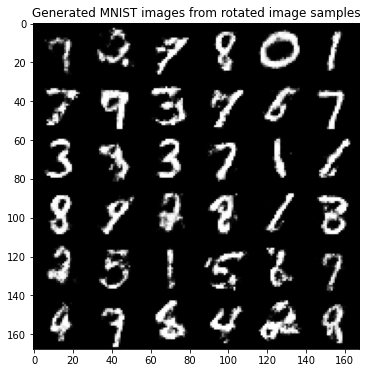

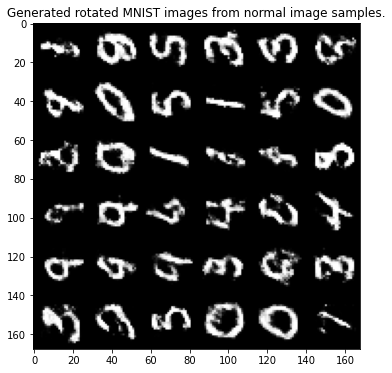

In [18]:
# Testing

n = 6
canvas1 = np.empty((28*n, 28*n))
canvas2 = np.empty((28*n, 28*n))

for i in range(n):
  test_A = shuffle_data(X_train_real, batch_size)
  test_B = shuffle_data(X_train_rot, batch_size)

  # Generate A images from B
  out_A = sess.run(X_BA, feed_dict={X_B: test_B})

  # Generate B images from A
  out_B = sess.run(X_AB, feed_dict={X_A: test_A})
  
  for j in range(n):
    # Draw the Generated Digits
    canvas1[i*28: (i + 1) *28, j* 28:(j+1) *28] = out_A[j].reshape([28,28])

  for j in range(n):
    # Draw the Generated Digits
    canvas2[i*28: (i + 1) *28, j* 28:(j+1) *28] = out_B[j].reshape([28,28])

# Generate Plots
plt.figure(figsize=(n, n))
plt.imshow(canvas1, origin = "upper", cmap = "gray")
plt.title("Generated MNIST images from rotated image samples")
plt.show()

plt.figure(figsize = (n,n))
plt.imshow(canvas2, origin="upper", cmap="gray")
plt.title("Generated rotated MNIST images from normal image samples.")
plt.show()